In [114]:
import cv2 as cv
import numpy as np
import math
from numpy import ndarray
from google.colab.patches import cv2_imshow

Откроем изображение и выведем его.

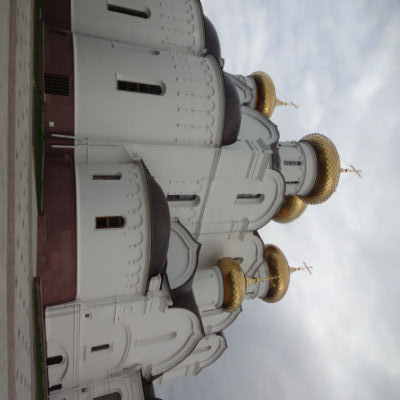

In [115]:
image = cv.imread('input.jpg')
cv2_imshow(image)

Зададим параметры угла поворота $\alpha$, значение коэффициента $k$ и признака интерполяционной схемы.

In [182]:
rotate_angle = 135
k = 0.5
interpolation_scheme = 0

In [183]:
def rotate(image: ndarray, rotate_angle: int) -> ndarray:
  (height, width) = image.shape[:2]
  center = (height // 2, width // 2)

  sin_a = np.abs(np.sin(math.radians(rotate_angle)))
  cos_a = np.abs(np.cos(math.radians(rotate_angle)))

  new_height = int(height * sin_a + width * cos_a)
  new_width = int(height * cos_a + width * sin_a)

  rotate_matrix = cv.getRotationMatrix2D(center, rotate_angle, 1.0)
  rotate_matrix[0, 2] += (new_width // 2) - center[1]
  rotate_matrix[1, 2] += (new_height // 2) - center[0]

  return cv.warpAffine(
      image,
      rotate_matrix,
      (new_width, new_height)
  )

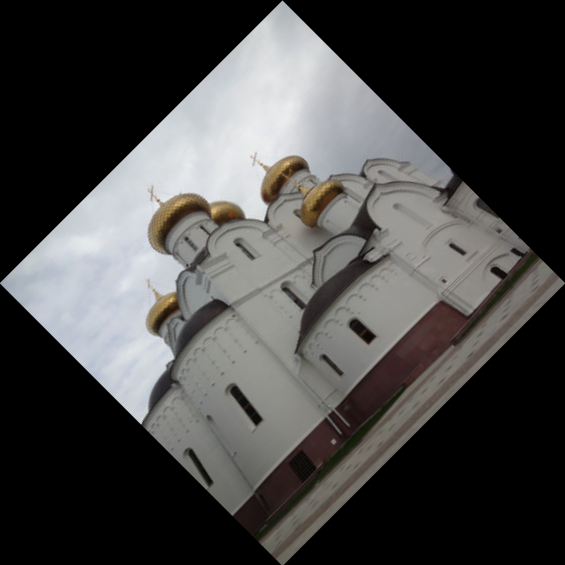

In [184]:
rotated_image = rotate(image, rotate_angle)
cv2_imshow(rotated_image)

In [189]:
def normalize_angle(angle: int) -> float:
    quadrant = (angle // 90) % 4
    sign_alpha = math.radians(angle) if quadrant % 2 == 0 else math.radians(180 - angle)
    return sign_alpha % math.pi

def largest_rectangle(height: int, width: int, rotate_angle: int) -> tuple:
  alpha = normalize_angle(rotate_angle)

  border = {
      "width" : width*np.cos(alpha) + height*np.sin(alpha),
      "height" : height*np.cos(alpha) + width*np.sin(alpha),
  }

  beta = np.arctan2(border['width'], border['height'])
  if border['width'] >= border['height']:
    beta = np.arctan2(border['height'], border['width'])

  gamma = np.pi/2 - alpha + beta
  side = max(height, width)

  g_side = side * np.cos(alpha)
  a_side = g_side * np.sin(alpha)/np.sin(gamma)

  return (
      int(border['width'] - 2 * a_side * np.sin(beta)),
      int(border['height'] - 2 * a_side * np.cos(beta))
  )

def crop_image(image: ndarray, width: int, height: int) -> ndarray:
    (image_height, image_width) = image.shape[:2]

    center = (image_height // 2, image_width // 2)

    width = min(width, image_width) // 2
    height = min(height, image_height) // 2

    x1 = int(center[1] - width)
    x2 = int(center[1] + width)
    y1 = int(center[0] - height)
    y2 = int(center[0] + height)

    return image[y1:y2, x1:x2]

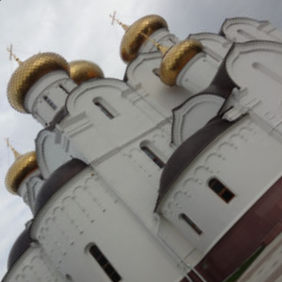

In [193]:
(height, width) = image.shape[:2]
cropped_image = crop_image(rotated_image, *largest_rectangle(height, width, rotate_angle))
cv2_imshow(cropped_image)

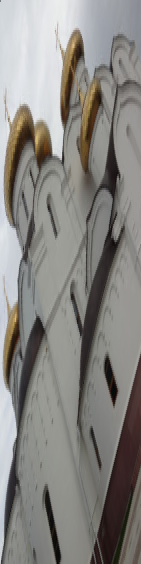

In [195]:
scheme = {
    0: cv.INTER_NEAREST,
    1: cv.INTER_LINEAR,
    2: cv.INTER_CUBIC
}

(h, w) = cropped_image.shape[:2]
base_points = (int(w * k), int(h / k))
resized_image = cv.resize(cropped_image, base_points, interpolation=scheme[interpolation_scheme])

cv2_imshow(resized_image)

In [196]:
cv.imwrite('result.bmp', resized_image)

True